In [5]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from typing import Iterable, Optional

# Read and Prepare Data

In [6]:
def normalize_vector(vector: Optional[np.ndarray], dim: Optional[int] = None) -> np.ndarray:
    norm = np.sqrt(np.sum(np.square(vector)))
    if norm > 0.001:
        return vector / norm
    else:
        return vector

In [7]:
name_embeds_df = pd.read_parquet("data/text_and_bert.parquet")[["variantid", "name_bert_64"]]
images_embeds_df = pd.read_parquet("data/resnet.parquet")[["variantid", "main_pic_embeddings_resnet_v1", "pic_embeddings_resnet_v1"]]
embeds_df = name_embeds_df.merge(images_embeds_df, on="variantid")
embeds_df["name_bert_64"] = embeds_df["name_bert_64"].apply(normalize_vector)
embeds_df["main_pic_embeddings_resnet_v1"] = embeds_df["main_pic_embeddings_resnet_v1"].apply(lambda x: normalize_vector(x[0]) if x is not None else np.zeros(128))
embeds_df["pic_embeddings_resnet_v1"] = embeds_df["pic_embeddings_resnet_v1"].apply(lambda x: normalize_vector(x[0]) if x is not None else np.zeros(128))

In [8]:
embed_dict = embeds_df.set_index("variantid").to_dict()
train_df, test_df = train_test_split(pd.read_parquet("data/train.parquet"), test_size=0.2, random_state=42)

In [9]:
class VariantPairDataset(Dataset):
    def __init__(
        self,
        variant_pairs: Iterable[tuple[int, int]],
        text_embeddings: dict[int, np.ndarray],
        img_embeddings: dict[int, np.ndarray],
        minor_img_embeddings: dict[int, np.ndarray],
        targets: np.ndarray
    ) -> None:
        self.variant_pairs = variant_pairs
        self.text_embeddings = text_embeddings
        self.img_embeddings = img_embeddings
        self.minor_img_embeddings = minor_img_embeddings
        self.targets = targets

    def __len__(self) -> int:
        return len(self.variant_pairs)

    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        variantid1, variantid2 = self.variant_pairs[idx]

        text_emb1 = self.text_embeddings[variantid1]
        img_emb1 = np.concatenate((self.img_embeddings[variantid1], self.minor_img_embeddings[variantid1]))
        text_emb2 = self.text_embeddings[variantid2]
        img_emb2 = np.concatenate((self.img_embeddings[variantid2], self.minor_img_embeddings[variantid2]))

        target = self.targets[idx]

        sample = {
            "text_emb1": torch.tensor(text_emb1, dtype=torch.float32),
            "img_emb1": torch.tensor(img_emb1, dtype=torch.float32),
            "text_emb2": torch.tensor(text_emb2, dtype=torch.float32),
            "img_emb2": torch.tensor(img_emb2, dtype=torch.float32),
            "target": torch.tensor(target, dtype=torch.float32)
        }

        return sample

In [10]:
train_dataset = VariantPairDataset(
    train_df[["variantid1", "variantid2"]].values,
    embed_dict["name_bert_64"],
    embed_dict["main_pic_embeddings_resnet_v1"],
    embed_dict["pic_embeddings_resnet_v1"],
    train_df["target"].values
)

test_dataset = VariantPairDataset(
    test_df[["variantid1", "variantid2"]].values,
    embed_dict["name_bert_64"],
    embed_dict["main_pic_embeddings_resnet_v1"],
    embed_dict["pic_embeddings_resnet_v1"],
    test_df["target"].values
)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=50000, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=50000, shuffle=False)

In [12]:
class PairwiseBinaryClassifier(nn.Module):
    def __init__(
        self,
        text_emb_size: int,
        img_emb_size: int,
        hidden_size: int,
        nlayers: int
    ) -> None:
        super(PairwiseBinaryClassifier, self).__init__()
        input_size = 2 * (text_emb_size + img_emb_size)
        layers = []
        for i in range(nlayers):
            layers.extend(
                [
                    nn.Linear(input_size if i == 0 else hidden_size, hidden_size),
                    nn.BatchNorm1d(hidden_size),
                    nn.PReLU(),
                    nn.Dropout(0.3)
                ]
            )
        self.layers = nn.Sequential(*layers)
        self.scorer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self._init_params()

    def _init_params(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(
        self,
        text_emb1: torch.Tensor,
        img_emb1: torch.Tensor,
        text_emb2: torch.Tensor,
        img_emb2: torch.Tensor,
    ) -> torch.Tensor:
        x = torch.cat((text_emb1, img_emb1, text_emb2, img_emb2), dim=-1)
        x = self.layers(x)
        x = self.sigmoid(self.scorer(x))
        return x

In [13]:
from typing import Optional


class Embedding(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(Embedding, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


class PairwiseEmbedOrientBinaryClassifier(nn.Module):
    def __init__(
        self,
        text_emb_size: int,
        img_emb_size: int,
        hidden_size: int,
        nlayers: int,
        img_embed_dim: Optional[int] = None
    ) -> None:
        super(PairwiseEmbedOrientBinaryClassifier, self).__init__()
        img_emb_dim = hidden_size // 2 if not img_embed_dim else img_embed_dim
        text_emb_dim = hidden_size - img_emb_dim
        assert text_emb_dim > 0
        self.img_embedder = Embedding(2 * img_emb_size, img_emb_dim)
        self.text_embedder = Embedding(2 * text_emb_size, text_emb_dim)
        layers = []
        for _ in range(nlayers):
            layers.extend(
                [
                    nn.Linear(hidden_size, hidden_size),
                    nn.BatchNorm1d(hidden_size),
                    nn.PReLU(),
                    nn.Dropout(0.3)
                ]
            )
        self.layers = nn.Sequential(*layers)
        self.scorer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self._init_params()

    def _init_params(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(
        self,
        text_emb1: torch.Tensor,
        img_emb1: torch.Tensor,
        text_emb2: torch.Tensor,
        img_emb2: torch.Tensor
    ) -> torch.Tensor:
        img_emb = self.img_embedder(torch.concat((img_emb1, img_emb2), dim=-1))
        text_emb = self.text_embedder(torch.concat((text_emb1, text_emb2), dim=-1))
        x= torch.concat((img_emb, text_emb), axis=1)
        x = self.layers(x)
        x = self.sigmoid(self.scorer(x))
        return x

In [14]:
class PairwiseItemOrientBinaryClassifier(nn.Module):
    def __init__(
        self,
        text_emb_size: int,
        img_emb_size: int,
        hidden_size: int,
        nlayers: int,
    ) -> None:
        super(PairwiseItemOrientBinaryClassifier, self).__init__()
        v1_embed_dim = hidden_size // 2
        v2_embed_dim = hidden_size - v1_embed_dim
        self.v1_embedder = Embedding(text_emb_size + img_emb_size, v1_embed_dim)
        self.v2_embedder = Embedding(text_emb_size + img_emb_size, v2_embed_dim)
        layers = []
        for _ in range(nlayers):
            layers.extend(
                [
                    nn.Linear(hidden_size, hidden_size),
                    nn.BatchNorm1d(hidden_size),
                    nn.PReLU(),
                    nn.Dropout(0.3)
                ]
            )
        self.layers = nn.Sequential(*layers)
        self.scorer = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self._init_params()

    def _init_params(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(
        self,
        text_emb1: torch.Tensor,
        img_emb1: torch.Tensor,
        text_emb2: torch.Tensor,
        img_emb2: torch.Tensor
    ) -> torch.Tensor:
        v1_emb = self.v1_embedder(torch.concat((text_emb1, img_emb1), dim=-1))
        v2_emb = self.v2_embedder(torch.concat((text_emb2, img_emb2), dim=-1))
        x = torch.concat((v1_emb, v2_emb), axis=1)
        x = self.layers(x)
        x = self.sigmoid(self.scorer(x))
        return x

In [14]:
model = PairwiseItemOrientBinaryClassifier(text_emb_size=64, img_emb_size=128*2, hidden_size=1024, nlayers=5)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
def evaluate_model(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    threshold: float = 0.5
) -> tuple[list[float], list[float], list[float], float]:
    model.eval()
    eval_loss = 0.0
    all_targets = []
    all_predictions = []
    all_probas = []

    with torch.no_grad():
        for batch in dataloader:
            targets = batch["target"]
            outputs = model(*list(batch.values())[:-1])
            loss = criterion(outputs, targets.view(-1, 1))
            predictions = (outputs > threshold).float()
            eval_loss += loss.item()

            all_targets.extend(targets.cpu().numpy().tolist())
            all_predictions.extend(predictions.squeeze().cpu().numpy().tolist())
            all_probas.extend(outputs.squeeze().cpu().numpy().tolist())

    return all_targets, all_predictions, all_probas, eval_loss / len(dataloader)


def train_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    n_epochs: int
) -> tuple[dict[str, torch.Tensor], float]:
    best_model_state = model.state_dict()
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        train_loss = 0.0
        model.train()
        for batch in train_dataloader:
            optimizer.zero_grad()
            outputs = model(*list(batch.values())[:-1])
            loss = criterion(outputs, batch["target"].view(-1, 1))
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        _, _, _, eval_loss = evaluate_model(model, test_dataloader, criterion)
        if eval_loss < best_val_loss:
            best_model_state = model.state_dict()
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {(train_loss / len(train_dataloader)):.4f}, Eval Loss: {eval_loss:.4f}")
    return best_model_state, best_val_loss

In [16]:
num_epochs = 20
best_model_state, best_val_loss = train_model(model, train_dataloader, test_dataloader, optimizer, criterion, num_epochs)

Epoch 1/20, Train Loss: 0.7388, Eval Loss: 0.6711
Epoch 2/20, Train Loss: 0.6352, Eval Loss: 0.6233
Epoch 3/20, Train Loss: 0.6089, Eval Loss: 0.5833
Epoch 4/20, Train Loss: 0.5745, Eval Loss: 0.5340
Epoch 5/20, Train Loss: 0.5139, Eval Loss: 0.4628
Epoch 6/20, Train Loss: 0.4661, Eval Loss: 0.4330
Epoch 7/20, Train Loss: 0.4381, Eval Loss: 0.4135
Epoch 8/20, Train Loss: 0.4183, Eval Loss: 0.3976
Epoch 9/20, Train Loss: 0.4046, Eval Loss: 0.3958
Epoch 10/20, Train Loss: 0.3956, Eval Loss: 0.3958
Epoch 11/20, Train Loss: 0.3890, Eval Loss: 0.3866
Epoch 12/20, Train Loss: 0.3833, Eval Loss: 0.3785
Epoch 13/20, Train Loss: 0.3779, Eval Loss: 0.3751
Epoch 14/20, Train Loss: 0.3726, Eval Loss: 0.3725
Epoch 15/20, Train Loss: 0.3684, Eval Loss: 0.3703
Epoch 16/20, Train Loss: 0.3630, Eval Loss: 0.3673
Epoch 17/20, Train Loss: 0.3595, Eval Loss: 0.3666
Epoch 18/20, Train Loss: 0.3550, Eval Loss: 0.3640
Epoch 19/20, Train Loss: 0.3506, Eval Loss: 0.3630
Epoch 20/20, Train Loss: 0.3474, Eval Lo

In [17]:
real, preds, probas, loss = evaluate_model(model, test_dataloader, criterion)

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc

# Compute evaluation metrics
accuracy = accuracy_score(real, preds)
precision = precision_score(real, preds)
recall = recall_score(real, preds)
prauc_precision, prauc_recall, _ = precision_recall_curve(real, probas)
prauc = auc(prauc_recall, prauc_precision)
f1 = f1_score(real, preds)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'PR-AUC: {prauc:.4f}')
print(f'F1 Score: {f1:.4f}')

Loss: 0.4670
Accuracy: 0.8370
Precision: 0.8254
Recall: 0.8382
PR-AUC: 0.8994
F1 Score: 0.8317


# Calibration

In [30]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


def plot_clibration_curves(real: np.ndarray, probas: np.ndarray, calibrated_probas: np.ndarray) -> None:
    prob_true, prob_pred = calibration_curve(real, probas, n_bins=100)
    prob_true_calibrated, prob_pred_calibrated = calibration_curve(real, calibrated_probas, n_bins=100)

    plt.figure(figsize=(10, 7))
    plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='Calibrated Model (Platt Scaling)')
    plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

In [31]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

val_probas = np.array(probas)
val_targets = np.array(real)

In [32]:
base_lr = LogisticRegression()
base_lr.fit(val_probas.reshape(-1, 1), val_targets)

LogisticRegression()

In [33]:
calibrator = CalibratedClassifierCV(estimator=base_lr, method='isotonic', cv=10)
calibrator.fit(val_probas.reshape(-1, 1), val_targets)

CalibratedClassifierCV(cv=10, estimator=LogisticRegression(), method='isotonic')

In [34]:
from sklearn.metrics import brier_score_loss, log_loss

calibrated_probas = calibrator.predict_proba(val_probas.reshape(-1, 1))[:, 1]
brier_score = brier_score_loss(val_targets, calibrated_probas)
logloss = log_loss(val_targets, calibrated_probas)

calibrated_preds = calibrator.predict(val_probas.reshape(-1, 1))
accuracy = accuracy_score(val_targets, calibrated_preds)
precision = precision_score(val_targets, calibrated_preds)
recall = recall_score(val_targets, calibrated_preds)
prauc_precision, prauc_recall, _ = precision_recall_curve(val_targets, calibrated_preds)
prauc = auc(prauc_recall, prauc_precision)
f1 = f1_score(val_targets, calibrated_preds)

print(f"Brier Score: {brier_score:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'PR-AUC: {prauc:.4f}')
print(f'F1 Score: {f1:.4f}')

Brier Score: 0.1180
Log Loss: 0.3785
Accuracy: 0.8372
Precision: 0.8335
Recall: 0.8262
PR-AUC: 0.8716
F1 Score: 0.8298


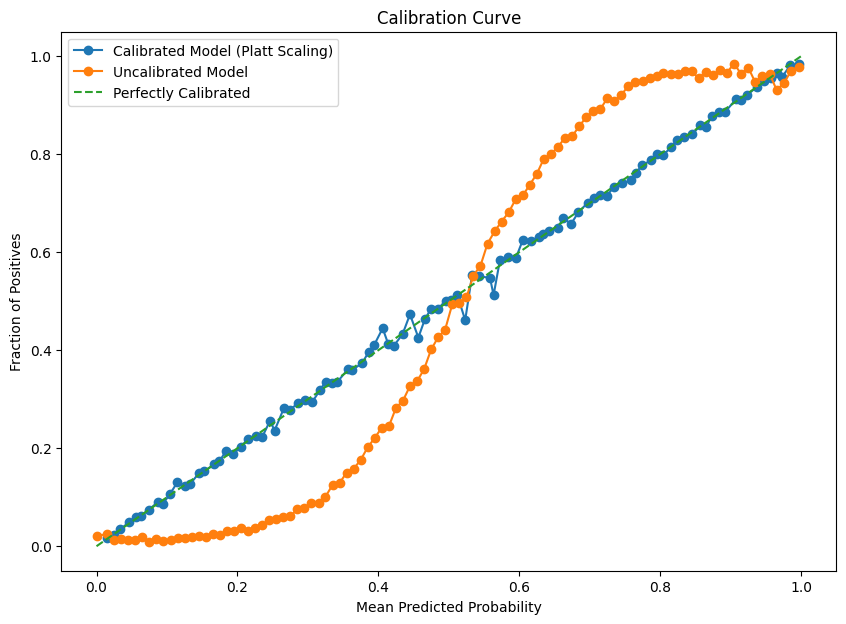

In [35]:
plot_clibration_curves(val_targets, probas, calibrated_probas)

# Compute Macro PRAUC

In [ ]:
model = PairwiseItemOrientBinaryClassifier(text_emb_size=64, img_emb_size=128*2, hidden_size=1024, nlayers=5)
criterion = nn.BCELoss()
model.load_state_dict(torch.load("models/pairwise_item_orient_classifier.pth"))

In [16]:
import json
attrs_df = pd.read_parquet("data/attributes.parquet")
attrs_df["category2"] = attrs_df["categories"].apply(lambda x: json.loads(x)["2"])
cat2_df = attrs_df[["variantid", "category2"]]

In [17]:
del attrs_df

In [18]:
test_cat2_df = test_df.merge(cat2_df, left_on="variantid1", right_on="variantid")                          \
                      .merge(cat2_df, left_on="variantid2", right_on="variantid", suffixes=("_v1", "_v2")) \
                      .drop(columns=["variantid_v1", "variantid_v2"])

In [19]:
test_cat2_df = test_cat2_df[test_cat2_df.category2_v1 == test_cat2_df.category2_v2] \
                           .drop(columns=["category2_v1"])                          \
                           .rename(columns={"category2_v2": "category2"})

In [20]:
test_categorized_dataset = VariantPairDataset(
    test_cat2_df[["variantid1", "variantid2"]].values,
    embed_dict["name_bert_64"],
    embed_dict["main_pic_embeddings_resnet_v1"],
    embed_dict["pic_embeddings_resnet_v1"],
    test_cat2_df["target"].values
)
test_categorized_dataloader = DataLoader(test_categorized_dataset, batch_size=250000, shuffle=False)

In [25]:
real, preds, probas, loss = evaluate_model(model, test_categorized_dataloader, criterion)

In [75]:
loss

0.11428450793027878

In [55]:
calibrated_probas = calibrator.predict_proba(np.array(probas).reshape(-1, 1))[:, 1]
preds = calibrator.predict(np.array(probas).reshape(-1, 1))

In [27]:
test_cat2_df["preds"] = preds
test_cat2_df["preds"] = test_cat2_df["preds"].astype(int)

In [28]:
test_cat2_df = test_cat2_df.rename(columns={"target": "target_true", "preds": "target_pred"})

In [29]:
test_cat2_df

,variantid1,variantid2,target_true,category2,pred,target_pred
0,938776155,473815138,1,Автотовары,1.0,1
1,1349745192,1349703019,0,Электроника,0.0,0
2,1450853415,1450853943,1,Обувь,1.0,1
3,741508506,413821437,0,Электроника,0.0,0
4,1337038519,1313965970,1,Бытовая техника,1.0,1
...,...,...,...,...,...,...
233699,1263293774,820239794,1,Дом и сад,1.0,1
233700,1044762753,1044952952,1,Автотовары,1.0,1
233701,603427449,610310911,0,Автотовары,1.0,1
233702,1096436741,1171163976,1,Мебель,1.0,1


In [30]:
def calculate_macro_prauc_by_category(df: pd.DataFrame, categories: np.ndarray) -> float:
    pr_auc_by_category = []

    for category in categories:
        cat_indices = df["category2"] == category
        y_true = df.loc[cat_indices, "target_true"]
        y_scores = df.loc[cat_indices, "target_pred"]

        if len(y_true) == 0 or sum(y_true) == 0:
            pr_auc_by_category.append(0)
            continue

        precision, recall, _ = precision_recall_curve(y_true, y_scores)

        pr_auc = auc(recall, precision)
        pr_auc_by_category.append(pr_auc)

    if len(pr_auc_by_category) == 0:
        return 0.0

    macro_prauc = np.mean(pr_auc_by_category)
    return macro_prauc

In [33]:
calculate_macro_prauc_by_category(df=test_cat2_df, categories=test_cat2_df["category2"].unique())

0.850387956565896

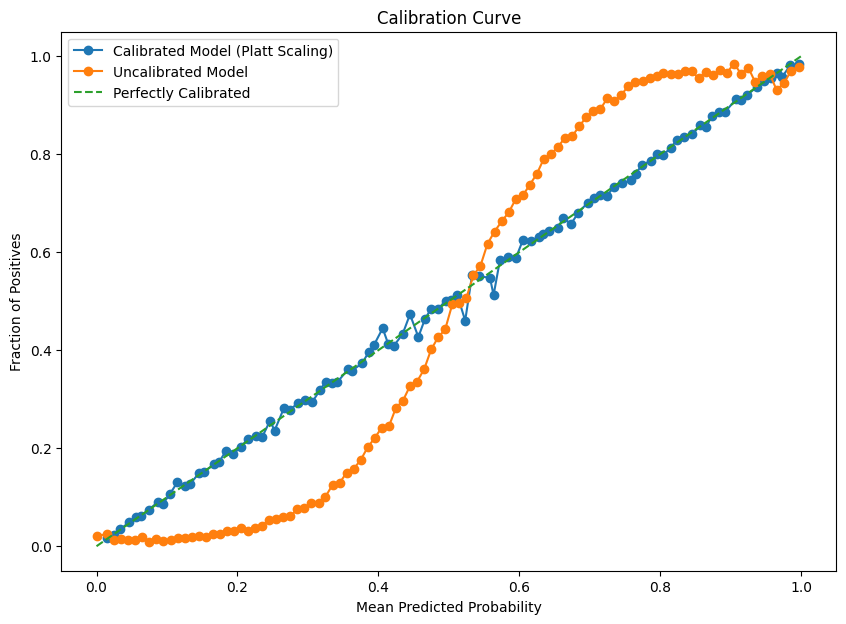

In [61]:
plot_clibration_curves(real, probas, calibrated_probas)

In [62]:
def calculate_prauc_by_category(df: pd.DataFrame, categories: np.ndarray) -> pd.DataFrame:
    pr_auc_results = []

    for category in categories:
        cat_indices = df["category2"] == category
        y_true = df.loc[cat_indices, "target_true"]
        y_scores = df.loc[cat_indices, "target_pred"]

        if len(y_true) == 0 or sum(y_true) == 0:
            pr_auc = 0
        else:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            pr_auc = auc(recall, precision)

        pr_auc_results.append({"category": category, "PR AUC": pr_auc})

    pr_auc_df = pd.DataFrame(pr_auc_results)
    pr_auc_df = pr_auc_df.sort_values(by="PR AUC", ascending=False)  # Сортировка по убыванию
    return pr_auc_df

calculate_prauc_by_category(df=test_cat2_df, categories=test_cat2_df["category2"].unique())

,category,PR AUC
2,Обувь,0.942055
9,Товары для взрослых,0.941077
15,Детские товары,0.933424
0,Автотовары,0.917080
10,Мебель,0.915512
5,Хобби и творчество,0.905454
6,Одежда,0.899335
3,Бытовая техника,0.885277
8,Книги,0.868806
12,Строительство и ремонт,0.850641


In [35]:
test_cat2_df[test_cat2_df["target_true"] != test_cat2_df["target_pred"]]

,variantid1,variantid2,target_true,category2,pred,target_pred
6,960828772,658026443,1,Хобби и творчество,0.0,0
10,1281794839,1285386921,1,Дом и сад,0.0,0
20,1445001065,1445000892,0,Одежда,1.0,1
34,1451233293,1461336265,1,Автотовары,0.0,0
42,835106559,1526098141,0,Бытовая техника,1.0,1
...,...,...,...,...,...,...
233674,50851912,558611475,0,Хобби и творчество,1.0,1
233682,1537458500,1537458285,0,Обувь,1.0,1
233690,1507130696,1495260660,0,Одежда,1.0,1
233691,1548812185,1548812002,0,Товары для животных,1.0,1


In [36]:
texts = pd.read_parquet("data/text_and_bert.parquet")

In [45]:
embeds = pd.read_parquet("data/embeddings.parquet")

In [50]:
np.dot(*embeds[embeds["variantid"].isin({960828772, 658026443})]["pic_embeddings_resnet_v1"].values)

0.0

In [39]:
texts[texts["variantid"].isin({960828772, 658026443})]

95237      Набор для опытов и экспериментов "Слайм лаб" "...
1751877    Набор для опытов и экспериментов.Юный химик Слайм
Name: name, dtype: object

# Save Model

In [84]:
import pickle

torch.save(tuned_model_state, "models/pairwise_item_orient_classifier_focal_tuned.pth")
with open("models/torch_calibrator.pkl", "wb") as f:
    pickle.dump(calibrator, f)
